# Time Series Analysis

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from tqdm import tqdm_notebook

from itertools import product

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
tnd_climate = pd.read_csv('data/clean/all_counties_tnd_climate_combined.csv')
tnd_climate.head()

,Year,County,AvgTmp,AvgMaxTmp,AvgMinTmp,AvgPrecip,TotPrecip,MaxTmp,MinTmp,AvgMag,Fat,Inj,Count,MaxMag,TndOcc
0,1950,Adams County,17.666667,28.400000,6.966667,1.576667,4.73,32.7,2.0,NaN,NaN,NaN,0.0,NaN,0
1,1950,Ashland County,11.333333,23.033333,-0.366667,1.650000,4.95,29.0,-7.0,NaN,NaN,NaN,0.0,NaN,0
2,1950,Barron County,12.133333,22.766667,1.466667,1.870000,5.61,28.4,-7.5,NaN,NaN,NaN,0.0,NaN,0
3,1950,Bayfield County,11.066667,23.066667,-0.933333,1.800000,5.40,29.5,-9.1,NaN,NaN,NaN,0.0,NaN,0
4,1950,Brown County,18.900000,27.966667,9.833333,2.156667,6.47,32.0,5.5,NaN,NaN,NaN,0.0,NaN,0


In [4]:
yearly_sums = tnd_climate.groupby('Year').sum()
yearly_means = tnd_climate.groupby('Year').mean()

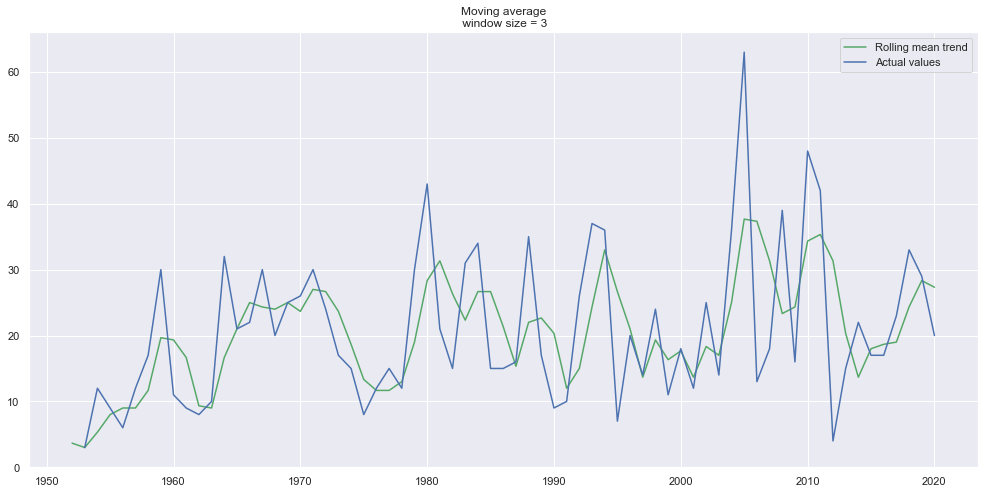

In [19]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)
    
plot_moving_average(yearly_sums['Count'], 3)

In [16]:
def exponential_smoothing(series, alpha):
    result = [series.iloc[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series.iloc[n] + (1 - alpha) * result[n-1])
    return result
  
def plot_exponential_smoothing(series, alphas):
 
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);

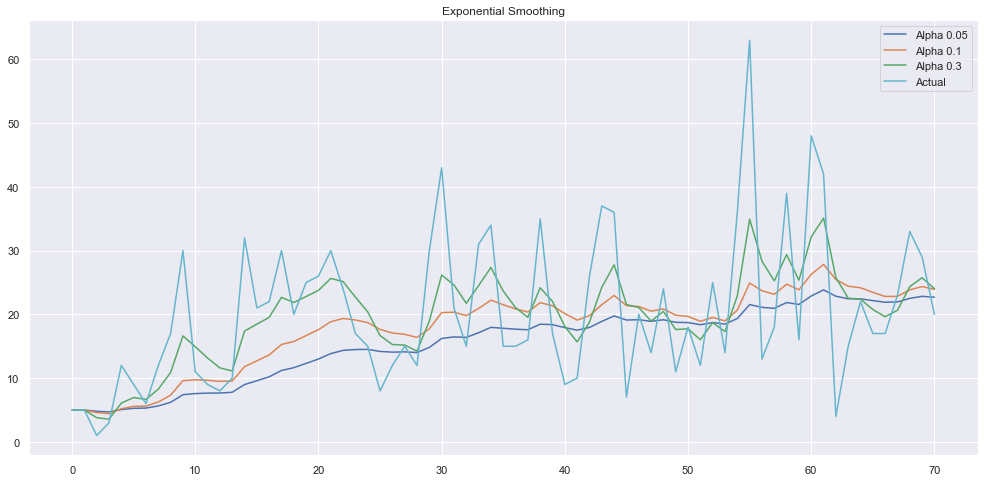

In [18]:
plot_exponential_smoothing(yearly_sums['Count'], [.05, 0.1, .3])

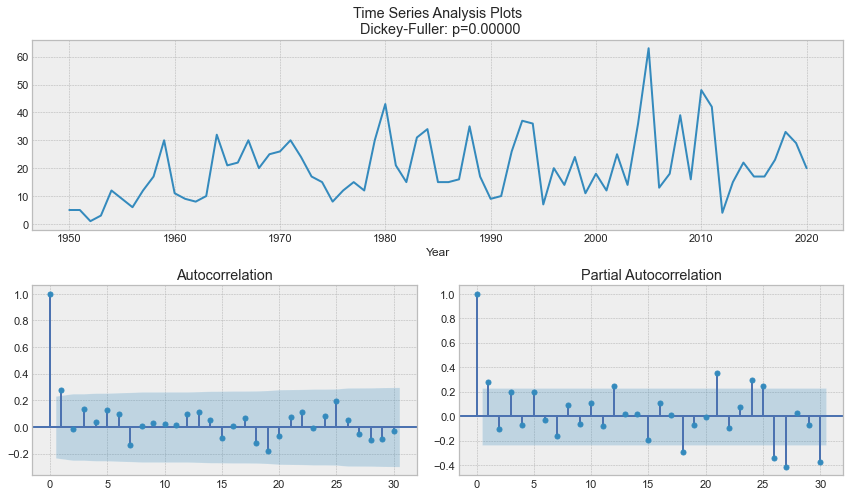

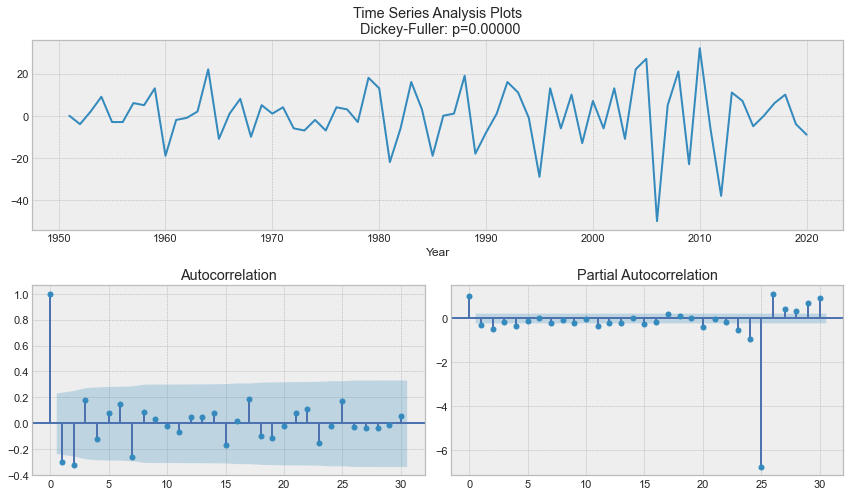

In [100]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(yearly_sums['Count'], lags=30)

# Take the first difference to remove to make the process stationary
data_diff = yearly_sums['Count'] - yearly_sums['Count'].shift(1)

tsplot(data_diff[1:], lags=30)

In [102]:
#Set initial values and some bounds
ps = range(0, 5)
d = 1
qs = range(0, 5)
Ps = range(0, 5)
D = 1
Qs = range(0, 5)
s = 5

#Create a list with all possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

def optimize_SARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
    """
    
    results = []
    best_aic = float('inf')
    
    for param in tqdm_notebook(parameters_list):
        try: model = sm.tsa.statespace.SARIMAX(yearly_sums['Count'], order=(param[0], d, param[1]),
                                               seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        
        #Save best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
        
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    #Sort in ascending order, lower AIC is better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

result_table = optimize_SARIMA(parameters_list, d, D, s)

#Set parameters that give the lowest AIC (Akaike Information Criteria)
p, q, P, Q = result_table.parameters[0]



  0%|          | 0/625 [00:00<?, ?it/s]

AttributeError: 'Series' object has no attribute 'CLOSE'

In [103]:
best_model = sm.tsa.statespace.SARIMAX(yearly_sums['Count'], order=(p, d, q),
                                       seasonal_order=(P, D, Q, s)).fit(disp=-1)

print(best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                               Count   No. Observations:                   71
Model:             SARIMAX(2, 1, 3)x(0, 1, [1], 5)   Log Likelihood                -252.366
Date:                             Sun, 01 May 2022   AIC                            518.733
Time:                                     18:13:28   BIC                            533.954
Sample:                                          0   HQIC                           524.739
                                              - 71                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5291      0.202     -7.588      0.000      -1.924      -1.134
ar.L2         -0.6437      